#  Altmetric Exploration Plots

This notebook contains the code to explore the altmetric data and create the first plots.

In [1]:
# Importing libraries


import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.collections as clt

import json
import pandas as pd

## Processing RetractionWatch

In [2]:
indir_plots = "/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_openalex/retraction_effects_on_academic_careers/plots/"
indir = "/Users/sm9654/desktop/NYUAD/nyuad-research/retraction_openalex/retraction_effects_on_academic_careers/data/"

df_papers = pd.read_csv(indir+"retraction_watch//RW_Original_wYear.csv",
                       usecols=['Record ID',
                               'RetractionDate',
                               'OriginalPaperDate',
                               'RetractionYear',
                               'OriginalPaperYear'])


df_filtered_sample = df_papers.copy() # just because df_filtered_sample was used in the legacy code (too lazy to edit)
df_filtered_sample

,Record ID,RetractionDate,OriginalPaperDate,OriginalPaperYear,RetractionYear
0,28599,2021-05-15,2016-11-07,2016.0,2021.0
1,28504,2021-05-14,2018-11-21,2018.0,2021.0
2,28506,2021-05-14,2019-08-15,2019.0,2021.0
3,28505,2021-05-14,2017-11-06,2017.0,2021.0
4,28502,2021-05-13,2018-09-06,2018.0,2021.0
...,...,...,...,...,...
26499,10433,1960-02-01,1955-02-01,1955.0,1960.0
26500,18529,1942-02-01,1942-02-01,1942.0,1942.0
26501,18531,1940-12-01,1940-12-01,1940.0,1940.0
26502,17246,1927-04-01,1926-04-01,1926.0,1927.0


In [3]:
# Removing anomalous data point from 1756

df_filtered_sample = df_filtered_sample[~df_filtered_sample.RetractionDate.eq('6/24/1756 12:00:00 AM') & 
                                       ~df_filtered_sample.RetractionDate.isna()].copy()

df_filtered_sample['Record ID'].shape

(26503,)

In [4]:
# Remvoing the seconds info as its ruining our formatting
# df_filtered_sample['OriginalPaperDate'] = df_filtered_sample['OriginalPaperDate'].str.split().str[0]

# df_filtered_sample['RetractionDate'] = df_filtered_sample['RetractionDate'].str.split().str[0]

# Converting RW Pub Date and Retraction Date to datetime format
df_filtered_sample['OriginalPaperDate'] = pd.to_datetime(df_filtered_sample.OriginalPaperDate, format='%Y-%m-%d')

# Converting Retraction Date to datetime format
df_filtered_sample['RetractionDate'] = pd.to_datetime(df_filtered_sample.RetractionDate, format='%Y-%m-%d')

df_filtered_sample

,Record ID,RetractionDate,OriginalPaperDate,OriginalPaperYear,RetractionYear
0,28599,2021-05-15,2016-11-07,2016.0,2021.0
1,28504,2021-05-14,2018-11-21,2018.0,2021.0
2,28506,2021-05-14,2019-08-15,2019.0,2021.0
3,28505,2021-05-14,2017-11-06,2017.0,2021.0
4,28502,2021-05-13,2018-09-06,2018.0,2021.0
...,...,...,...,...,...
26498,825,1966-10-01,1959-10-01,1959.0,1966.0
26499,10433,1960-02-01,1955-02-01,1955.0,1960.0
26500,18529,1942-02-01,1942-02-01,1942.0,1942.0
26501,18531,1940-12-01,1940-12-01,1940.0,1940.0


In [5]:
df_filtered_sample['OriginalPaperDate']

0       2016-11-07
1       2018-11-21
2       2019-08-15
3       2017-11-06
4       2018-09-06
           ...    
26498   1959-10-01
26499   1955-02-01
26500   1942-02-01
26501   1940-12-01
26502   1926-04-01
Name: OriginalPaperDate, Length: 26503, dtype: datetime64[ns]

## Processing Altmetric

In [6]:
# Let us first get the list of files from API

valid_rids = set(os.listdir(indir+"processed/altmetric_data/new_collection_dec2022/explorer_style_files/"))

valid_rids = [int(rid.split(".")[0]) for rid in valid_rids]
filtered_sample_rids = df_filtered_sample[~df_filtered_sample.RetractionYear.isna()]['Record ID'].unique()

len(valid_rids), len(filtered_sample_rids)

(11265, 26503)

In [7]:
# Now let us only read the explorer data for which data from API is available

indir_api = indir+"processed/altmetric_data/new_collection_dec2022/explorer_style_files/"

dfs = []
dfs_filtered_sample = []

counter_zero = 0
for rid in valid_rids:
    df_i = None
    df_i = pd.read_csv(indir_api+str(rid)+".csv").rename(columns={'Date':'MentionDate'})
    
    if(df_i.shape[0] != 0):
        
        # Let us first compute the total number of mentions for each day
        # Select columns that end with 'mentions'
        mentions_columns = [col for col in df_i.columns if col.endswith('mentions')]

        # Sum those columns row-wise to create a new 'Total mentions' column
        
        df_i['TotalMentions'] = df_i[mentions_columns].sum(axis=1)
        
        
        df_i['MentionDate'] = pd.to_datetime(df_i.MentionDate, format='%Y-%m-%d')
        df_i['Record ID'] = rid
        df_merged_i = df_i.merge(df_filtered_sample,
                                on='Record ID',how='left')
        df_merged_i['DaysToMentionFromPublicationDate'] = (df_merged_i['MentionDate'] - \
                                                         df_merged_i['OriginalPaperDate']).dt.days

        df_merged_i['DaysToMentionFromRetraction'] = (df_merged_i['MentionDate'] - \
                                                         df_merged_i['RetractionDate']).dt.days
        
        df_merged_i['MonthsToMentionFromRetraction'] = ((df_merged_i['MentionDate'] - \
                                                         df_merged_i['RetractionDate'])/np.timedelta64(1, 'M'))
        
        df_merged_i['WeeksToMentionFromRetraction'] = ((df_merged_i['MentionDate'] - \
                                                         df_merged_i['RetractionDate'])/np.timedelta64(1, 'W'))
        
        df_merged_i['YearsToMentionFromRetraction'] = ((df_merged_i['MentionDate'] - \
                                                         df_merged_i['RetractionDate'])/np.timedelta64(1, 'Y'))

        dfs.append(df_merged_i)
        
        if rid in filtered_sample_rids:
            dfs_filtered_sample.append(df_merged_i)
        
    else:
        counter_zero += 1


In [8]:
dfs[0].columns

Index(['MentionDate', 'Blog mentions', 'F1000 mentions', 'Facebook mentions',
       'Google+ mentions', 'LinkedIn mentions', 'News mentions',
       'Patent mentions', 'Peer review mentions', 'Pinterest mentions',
       'Policy mentions', 'Q&A mentions', 'Reddit mentions',
       'Twitter mentions', 'Video mentions', 'Weibo mentions',
       'Wikipedia mentions', 'TotalMentions', 'Record ID', 'RetractionDate',
       'OriginalPaperDate', 'OriginalPaperYear', 'RetractionYear',
       'DaysToMentionFromPublicationDate', 'DaysToMentionFromRetraction',
       'MonthsToMentionFromRetraction', 'WeeksToMentionFromRetraction',
       'YearsToMentionFromRetraction'],
      dtype='object')

In [9]:
len(dfs)

9480

In [10]:
dftemp = pd.concat(dfs)
dftemp

,MentionDate,Blog mentions,F1000 mentions,Facebook mentions,Google+ mentions,LinkedIn mentions,News mentions,Patent mentions,Peer review mentions,Pinterest mentions,...,Record ID,RetractionDate,OriginalPaperDate,OriginalPaperYear,RetractionYear,DaysToMentionFromPublicationDate,DaysToMentionFromRetraction,MonthsToMentionFromRetraction,WeeksToMentionFromRetraction,YearsToMentionFromRetraction
0,2017-10-05,0,0,0,0,0,0,0,0,0,...,5033,2013-05-14,2006-08-08,2006.0,2013.0,4076.0,1605,51.774194,229.285714,4.397260
0,2012-04-25,1,0,0,0,0,0,0,0,0,...,2353,2012-04-01,2011-12-22,2011.0,2012.0,125.0,24,0.774194,3.428571,0.065753
0,2015-06-14,0,0,0,0,0,0,0,0,0,...,5586,2009-12-19,2007-02-01,2007.0,2009.0,3055.0,2003,64.612903,286.142857,5.487671
1,2019-11-22,1,0,0,0,0,0,0,0,0,...,5586,2009-12-19,2007-02-01,2007.0,2009.0,4677.0,3625,116.935484,517.857143,9.931507
0,2018-02-09,0,0,0,0,0,0,0,0,0,...,16521,2017-10-01,2017-07-29,2017.0,2017.0,195.0,131,4.225806,18.714286,0.358904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2018-04-03,0,0,0,0,0,0,0,0,0,...,18384,2018-06-05,2013-11-13,2013.0,2018.0,1602.0,-63,-2.032258,-9.000000,-0.172603
0,2015-06-16,0,0,0,0,0,0,0,0,0,...,1604,2015-11-01,2015-09-15,2015.0,2015.0,-91.0,-138,-4.451613,-19.714286,-0.378082
1,2015-06-18,0,0,0,0,0,0,0,0,0,...,1604,2015-11-01,2015-09-15,2015.0,2015.0,-89.0,-136,-4.387097,-19.428571,-0.372603
2,2015-11-02,0,0,0,0,0,0,0,0,0,...,1604,2015-11-01,2015-09-15,2015.0,2015.0,48.0,1,0.032258,0.142857,0.002740


In [11]:
dftemp['Record ID'].nunique()

9480

In [12]:
len(dfs_filtered_sample)

9480

In [13]:
dfs_filtered_sample[0]

,MentionDate,Blog mentions,F1000 mentions,Facebook mentions,Google+ mentions,LinkedIn mentions,News mentions,Patent mentions,Peer review mentions,Pinterest mentions,...,Record ID,RetractionDate,OriginalPaperDate,OriginalPaperYear,RetractionYear,DaysToMentionFromPublicationDate,DaysToMentionFromRetraction,MonthsToMentionFromRetraction,WeeksToMentionFromRetraction,YearsToMentionFromRetraction
0,2017-10-05,0,0,0,0,0,0,0,0,0,...,5033,2013-05-14,2006-08-08,2006.0,2013.0,4076,1605,51.774194,229.285714,4.39726


In [14]:
# Let us now write a function that will compute Altmetric score for each month for a given rid
source_to_weights = {'Blog': 5,
     'F1000': 1,
     'Facebook': 0.25,
     'Google+': 1,
     'LinkedIn': 0.5,
     'News': 8,
     'Patent': 3,
     'Peer review': 1,
     'Pinterest': 0.25,
     'Policy': 3,
     'Q&A': 0.25,
     'Reddit': 0.25,
     'Twitter': 0.25,
     'Video':0.25,
     'Weibo':1,
     'Wikipedia':3}

def categorize_time_a(time):
    if(time == 0):
        return 1
    elif(time < 0):
        return int(np.floor(time))
    else:
        return int(np.ceil(time))

def compute_altmetric_score(row, suffix=" mentions"):
    score = 0
    for source in source_to_weights.keys():
        score += row[source+suffix] * source_to_weights.get(source)
    return score

def compute_altmetric_score_monthly6(dfi, lowMonth=-6, highMonth=6):
    """
    This function will compute the altmetric score for a given record id for each month
    for a 6 month period before and after retraction
    """
    
    months = {-6,-5,-4,-3,-2,-1,1,2,3,4,5,6}
    
    df_relevant = dfi[dfi.MonthsToMentionFromRetraction.le(highMonth) &
                           dfi.MonthsToMentionFromRetraction.ge(lowMonth)].copy()
    
    if(df_relevant.shape[0] > 0):
        rid = df_relevant['Record ID'].unique()[0]

        df_relevant['TimeCategory'] = df_relevant['MonthsToMentionFromRetraction'].\
                apply(categorize_time_a)
        
        df_relevant = df_relevant.reset_index()
        
        # Adding missing rows
        timecategories_present = set(df_relevant['TimeCategory'].unique())
        timecategories_absent = months - timecategories_present
        
        sourceLst = [s+" mentions" for s in source_to_weights.keys()]

        df_relevant_sum = df_relevant.reset_index().groupby('TimeCategory')[sourceLst].sum()
        
        df_relevant_sum['AltmetricScore'] = df_relevant_sum.apply(lambda row:\
                                            compute_altmetric_score(row, suffix=" mentions"),
                                            axis=1)
        df_relevant_sum['Group'] = 'Overall'

        df_relevant_sum['Record ID'] = rid
        
        df_relevant_sum = df_relevant_sum.reset_index()
        #print(df_relevant_sum.columns, df_relevant_sum.shape)
        # Now imputing the rows not available within -6,6 months
        lst_imputation = []
        
        for ti in timecategories_absent:
            new_row = [ti] + [0] * len(source_to_weights.keys()) + [0.0, 'Overall', rid]
            lst_imputation.append(new_row)
        
        df_imputed = pd.DataFrame(lst_imputation,columns=df_relevant_sum.columns)
        
        df_relevant_imputed = pd.concat([df_relevant_sum, df_imputed])

        return df_relevant_imputed

    else:
        return pd.DataFrame()

lst_df_total = []
lst_df_total_filtered_sample = []

for dfi in dfs_filtered_sample:
    lst_df_total_filtered_sample.append(compute_altmetric_score_monthly6(dfi))
    
for dfi in dfs:
    lst_df_total.append(compute_altmetric_score_monthly6(dfi))
    
df_total = pd.concat(lst_df_total)

df_total_filtered_sample = pd.concat(lst_df_total_filtered_sample)

df_total

,TimeCategory,Blog mentions,F1000 mentions,Facebook mentions,Google+ mentions,LinkedIn mentions,News mentions,Patent mentions,Peer review mentions,Pinterest mentions,Policy mentions,Q&A mentions,Reddit mentions,Twitter mentions,Video mentions,Weibo mentions,Wikipedia mentions,AltmetricScore,Group,Record ID
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,Overall,2353
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,2353
1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,2353
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,2353
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,2353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,1604
6,-6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,1604
7,-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,1604
8,-3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,Overall,1604


In [15]:
df_total_filtered_sample['LogAltmetricScore'] = np.log(df_total_filtered_sample['AltmetricScore']+0.01)

In [16]:
df_total_filtered_sample['Record ID'].nunique()

6507

In [17]:
df_total_filtered_sample

,TimeCategory,Blog mentions,F1000 mentions,Facebook mentions,Google+ mentions,LinkedIn mentions,News mentions,Patent mentions,Peer review mentions,Pinterest mentions,...,Q&A mentions,Reddit mentions,Twitter mentions,Video mentions,Weibo mentions,Wikipedia mentions,AltmetricScore,Group,Record ID,LogAltmetricScore
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.0,Overall,2353,1.611436
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,2353,-4.605170
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,2353,-4.605170
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,2353,-4.605170
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,2353,-4.605170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,-2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,1604,-4.605170
6,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,1604,-4.605170
7,-4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,1604,-4.605170
8,-3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,Overall,1604,-4.605170


In [18]:
df_total_filtered_sample[df_total_filtered_sample.TimeCategory.eq(1)].AltmetricScore.describe()

count     6507.000000
mean        20.946250
std        328.781973
min          0.000000
25%          0.000000
50%          0.500000
75%          6.000000
max      24479.750000
Name: AltmetricScore, dtype: float64

In [19]:
df_total_filtered_sample.groupby('Record ID')['AltmetricScore'].max().describe()

count     6507.000000
mean        33.150645
std        390.628854
min          0.250000
25%          1.000000
50%          5.000000
75%         10.000000
max      24479.750000
Name: AltmetricScore, dtype: float64

In [20]:
df_total_filtered_sample[df_total_filtered_sample['Record ID'].isin(df_filtered_sample['Record ID'])]['Record ID'].nunique()

6507

{'zorder': 0, 's': 9, 'edgecolor': 'white', 'linewidth': 0}


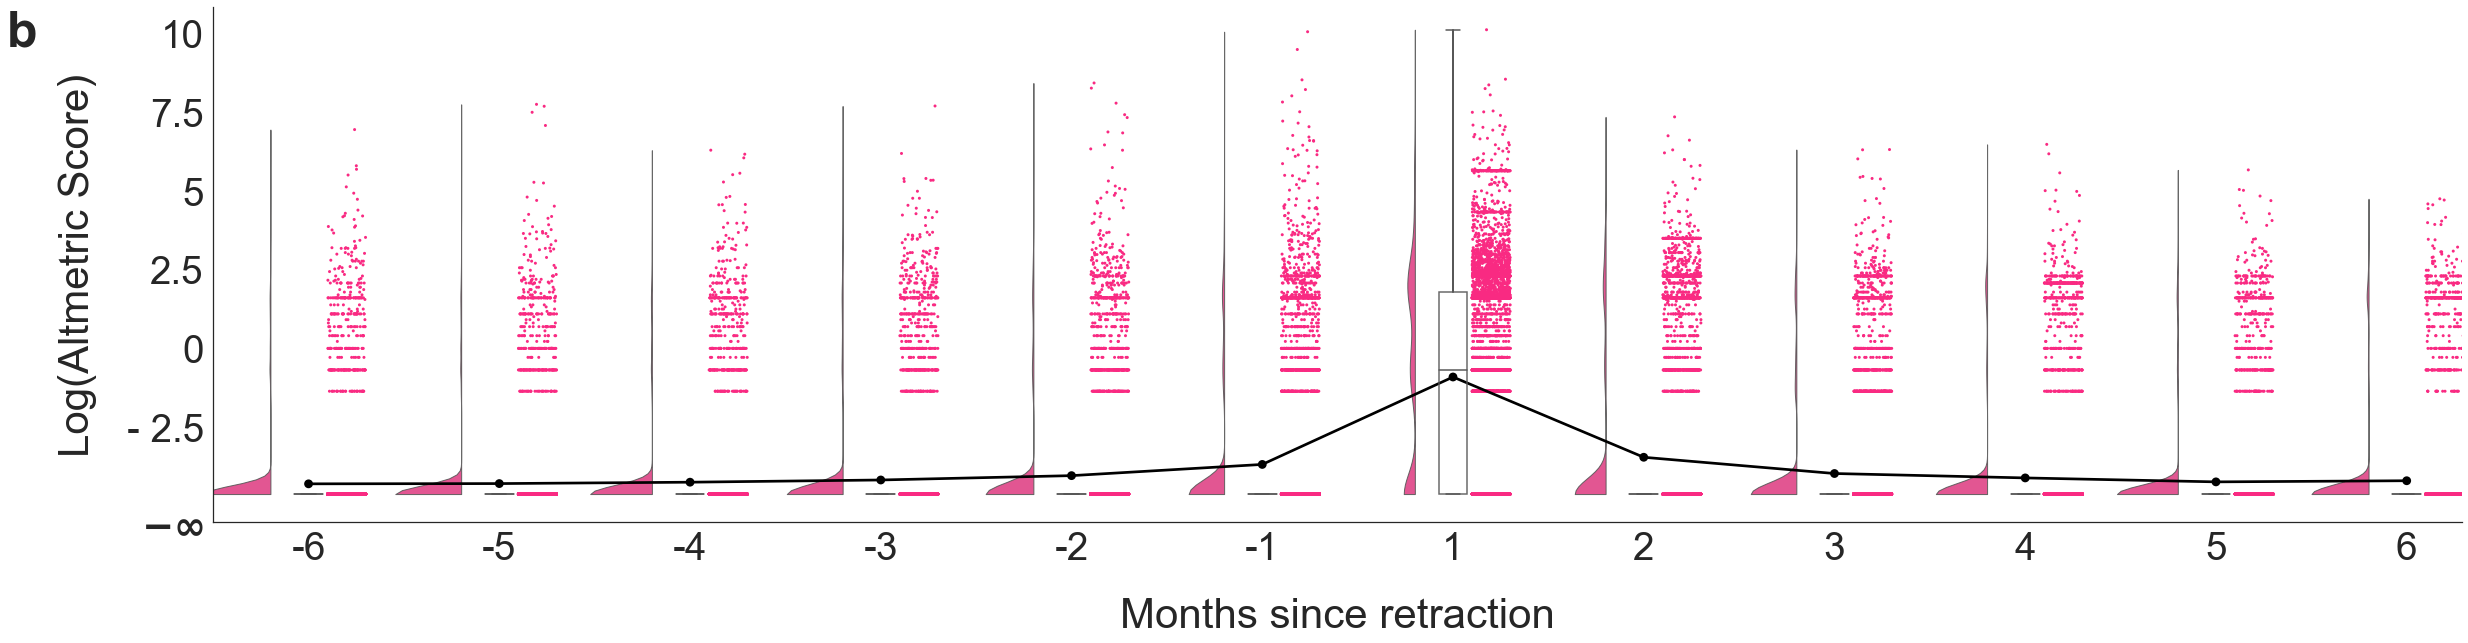

In [21]:
import ptitprince as pt
import numpy as np

sns.set(style="white",font_scale=3.5)
sigma = .2

dx = "TimeCategory"; dy = "LogAltmetricScore"; dhue = "Group"
f, ax = plt.subplots(figsize=(35, 10))

pal = ['#F92A82','#7EB77F']
pal = ['#F92A82','#F92A82']

ax=pt.RainCloud(x = dx, y = dy, data = df_total_filtered_sample, 
                palette = pal, bw = sigma, width_viol = .7,
                linecolor='black', box_showfliers = False,
                ax = ax, orient = "v" , alpha = .90, dodge = True, pointplot = True, move = .2)

#plt.title("Logged Altmetric Score Across 6 Months Before and After Retraction")
plt.xlabel('Months since retraction', labelpad=30)
plt.ylabel('Log(Altmetric Score)', labelpad=30)

# Set custom y-ticks
ax.set_yticks([-5.5, -2.5, 0, 2.5, 5, 7.5, 10])
ax.set_yticklabels([r'$\mathbf{-\infty}$', '- 2.5', '0', '2.5', '5', '7.5', '10'])
ax.set_ylim(-5.5,)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add "b" label
ax.text(-1.5, 10, "b", fontsize=50, ha='center', va='center', fontweight='bold')

plt.tight_layout()

plt.show()

#plt.savefig(indir_plots+'/attention_new.pdf', format='pdf', dpi=1200)
#plt.savefig(indir_plots+'/attention_new.svg', format='svg')

## RainCloud Plots

In [22]:
def create_df4plot(dfs,sourceLst=['Twitter mentions'], timefield='MonthsToMentionFromRetraction', timelimit=6,
                  groupRoot = 'Twitter'):
    df_percentages = []
    defaultCols = ['Record ID',timefield]
    
    months = {-6,-5,-4,-3,-2,-1,1,2,3,4,5,6}
    
    # Going through each paper
    for df_i in dfs:

        # Let us first remove rows that are not irrelevant
        df_relevant = df_i[df_i[timefield].abs().le(timelimit)][defaultCols+sourceLst]
        
        # Computing Total mentionss
        df_relevant['TotalPartialMentions'] = df_relevant[sourceLst].sum(axis=1)

        # Now we need to categorize time

        df_relevant['TimeCategory'] = df_relevant[timefield].apply(categorize_time_a)

        
        # For each times category, we shall compute the total number of mentions
        df_grouped = df_relevant.groupby('TimeCategory')['TotalPartialMentions'].sum().reset_index()

        # Adding missing rows
        timecategories_present = set(df_grouped['TimeCategory'].unique())
        timecategories_absent = months - timecategories_present
        lst_imputation = []
        
        for ti in timecategories_absent:
            new_row = [ti,0]
            lst_imputation.append(new_row)
        
        df_imputed = pd.DataFrame(lst_imputation,columns=df_grouped.columns)
        
        df_grouped = pd.concat([df_grouped, df_imputed])
        
        # Now we shall compute the percentage for mentions
        
        if(df_grouped['TotalPartialMentions'].sum() != 0):

            df_grouped['PercentageTotalMentions'] = df_grouped['TotalPartialMentions']*100/df_grouped['TotalPartialMentions'].sum()

            df_grouped['Group'] = groupRoot

            df_grouped['Record ID'] = df_i['Record ID'].unique()[0]

            df_percentages.append(df_grouped)

    return df_percentages


### RainCloud Plot for 6 Months Pre- and Post- Retraction for Total Mentions (Unweighted)

In [23]:
for i in range(len(dfs_filtered_sample)):
    dfi = dfs_filtered_sample[i]
    if(dfi['Record ID'].tolist()[0]==21098):
        print(dfi.columns)

Index(['MentionDate', 'Blog mentions', 'F1000 mentions', 'Facebook mentions',
       'Google+ mentions', 'LinkedIn mentions', 'News mentions',
       'Patent mentions', 'Peer review mentions', 'Pinterest mentions',
       'Policy mentions', 'Q&A mentions', 'Reddit mentions',
       'Twitter mentions', 'Video mentions', 'Weibo mentions',
       'Wikipedia mentions', 'TotalMentions', 'Record ID', 'RetractionDate',
       'OriginalPaperDate', 'OriginalPaperYear', 'RetractionYear',
       'DaysToMentionFromPublicationDate', 'DaysToMentionFromRetraction',
       'MonthsToMentionFromRetraction', 'WeeksToMentionFromRetraction',
       'YearsToMentionFromRetraction'],
      dtype='object')


In [24]:
df_percentages_6months_total = create_df4plot(dfs_filtered_sample, sourceLst=['TotalMentions'], 
                                timefield='MonthsToMentionFromRetraction', timelimit=6, groupRoot='Overall')

In [25]:
df_percentages_concat_6months_total = pd.concat(df_percentages_6months_total)
df_percentages_concat_6months_total.head()

,TimeCategory,TotalPartialMentions,PercentageTotalMentions,Group,Record ID
0,1,1,100.0,Overall,2353
0,2,0,0.0,Overall,2353
1,3,0,0.0,Overall,2353
2,4,0,0.0,Overall,2353
3,5,0,0.0,Overall,2353


In [26]:
df_percentages_concat_6months_total['Record ID'].nunique()

6507

In [27]:
df_percentages_concat_6months_total['Group'].value_counts()

Group
Overall    78084
Name: count, dtype: int64

In [28]:
# Defining broads categories for sources

source_to_category = {'Social Media':['Twitter mentions', 'Facebook mentions',
                                      'Google+ mentions', 'LinkedIn mentions', 'Reddit mentions',
                                       'Pinterest mentions','Video mentions'],
                      'News Media': ['News mentions'],
                      'Blogs':['Blog mentions'],
                      'Knowledge Repositories':['Patent mentions','Peer review mentions',
                                               'Wikipedia mentions','F1000 mentions',
                                               'Q&A mentions']
                     }


In [29]:
dfs_4sourcetypes = []

for source in source_to_category.keys():
    print("Working on", source)
    
    lst_dfs_percentages_6months_source = create_df4plot(dfs_filtered_sample, sourceLst=source_to_category.get(source), 
                                timefield='MonthsToMentionFromRetraction', timelimit=6, groupRoot=source)
    
    df_percentages_6months_source = pd.concat(lst_dfs_percentages_6months_source)
    
    dfs_4sourcetypes.append(df_percentages_6months_source)

Working on Social Media
Working on News Media
Working on Blogs
Working on Knowledge Repositories


In [30]:
# Now let us merge the four types of sources i.e. Total Mentions and Twitter mentions
df_percentages_concat_6months_4types = pd.concat(dfs_4sourcetypes)


In [31]:
df_mention_counts = df_percentages_concat_6months_4types.\
                        groupby('Record ID')['TotalPartialMentions'].sum().reset_index().\
                        rename(columns={'TotalPartialMentions':'TotalMentions'})

df_4types_w_counts = df_percentages_concat_6months_4types.merge(df_mention_counts, on='Record ID')

df_4types_w_counts = df_4types_w_counts[df_4types_w_counts.TotalMentions.ne(0)]

df_4types_w_counts['PercentageTotalMentions'] = df_4types_w_counts['PercentageTotalMentions'].\
                                                    astype(float)

{'zorder': 0, 's': 9, 'edgecolor': 'white', 'linewidth': 0}
{'zorder': 0, 's': 9, 'edgecolor': 'white', 'linewidth': 0}
{'zorder': 0, 's': 9, 'edgecolor': 'white', 'linewidth': 0}
{'zorder': 0, 's': 9, 'edgecolor': 'white', 'linewidth': 0}


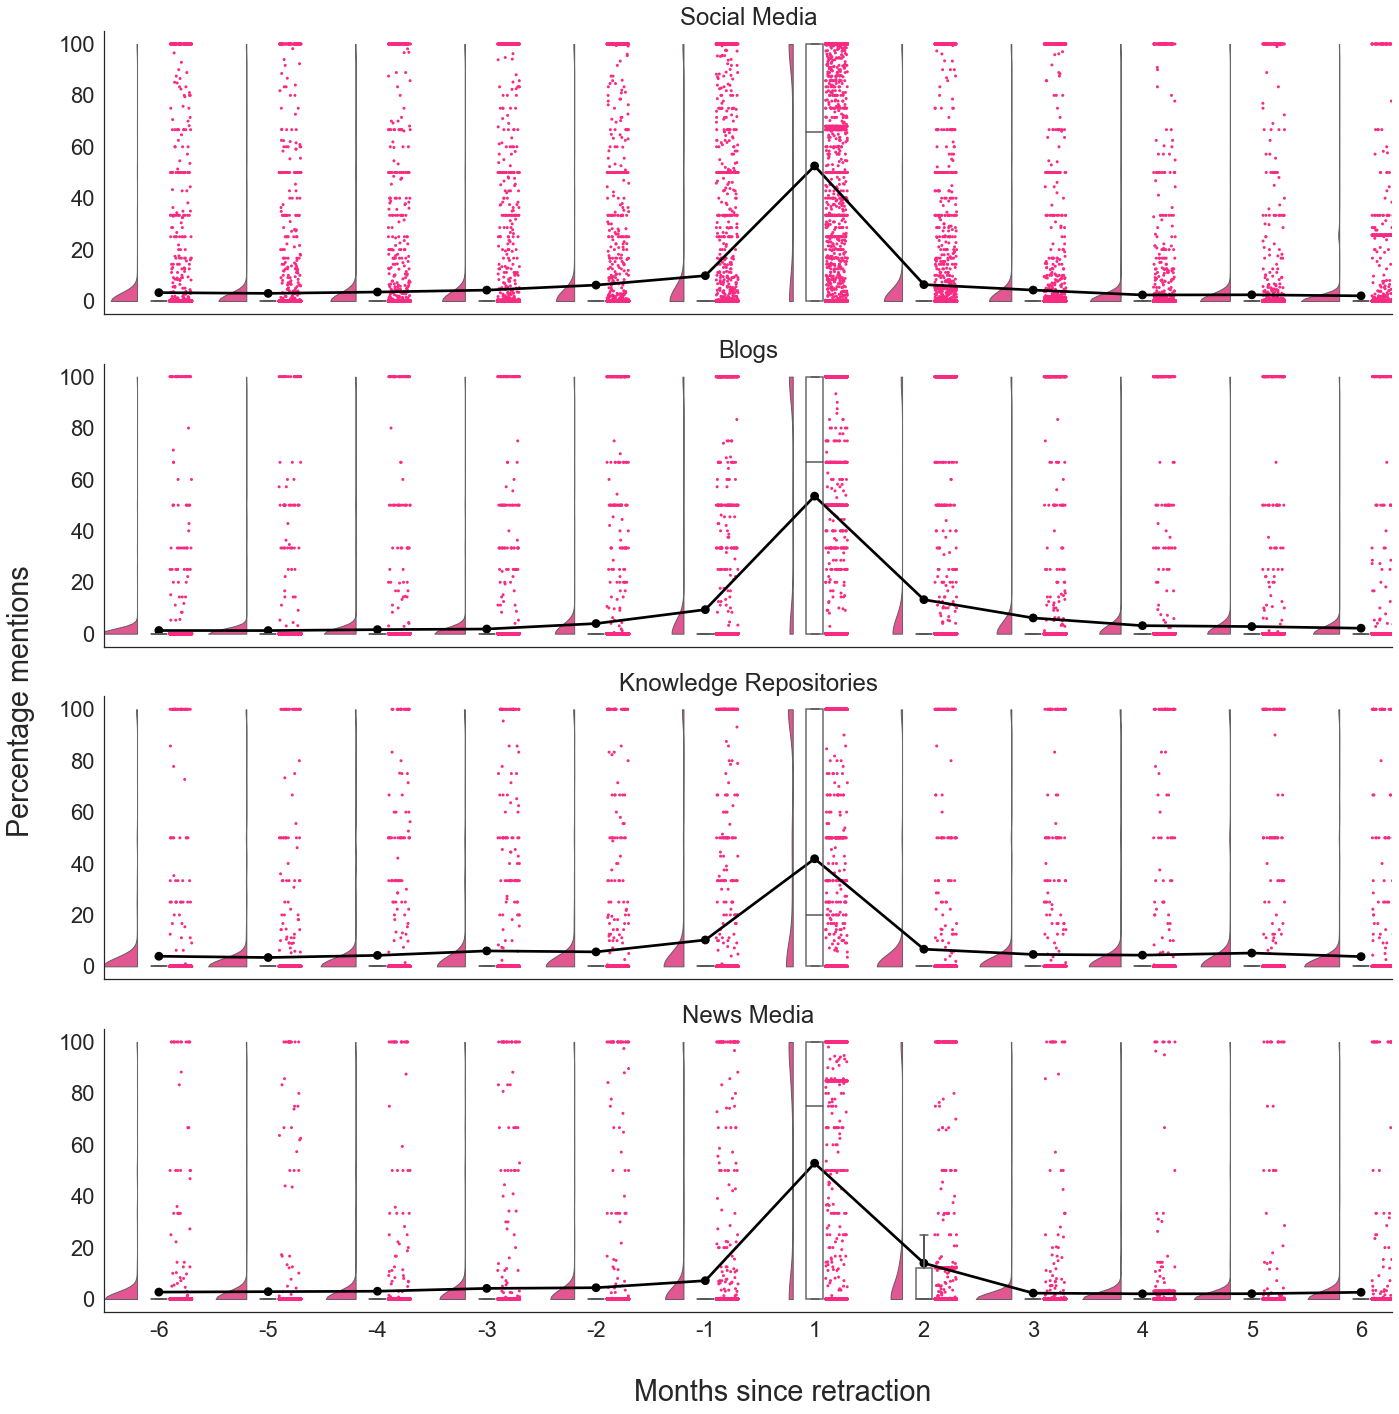

In [32]:
# Combining all the plots

pal = ['#F92A82','#7EB77F']
pal = ['#F92A82','#F92A82']
sns.set(style="white",font_scale=2)

g = sns.FacetGrid(df_4types_w_counts, 
                  row = "Group", height=5, aspect=4,)

g = g.map_dataframe(pt.RainCloud, x = "TimeCategory", y = "PercentageTotalMentions", 
                    data = df_4types_w_counts, box_showfliers = False,
                     palette = pal, bw = sigma, width_viol = .7,
                    alpha = .90, dodge = True, pointplot = True, move = .2,
                    orient = "v", linecolor='black')


g.fig.supxlabel('                     Months since retraction')
g.fig.supylabel('Percentage mentions')
g.set_titles('{row_name}')

g.fig.tight_layout()

#plt.savefig(indir_plots+'/raincloud_all_sources_fromAPI_new.png', format='png')